# NLTK Sentiment Intensity Analyzer (SIA)
Data file:
* https://raw.githubusercontent.com/vjavaly/Baruch-CIS-9665/main/data/Womens_clothing_ECommerce_reviews_5k.csv
  * Independent variables
    * Title: String variable for the title of the review
    * Review Text: String variable for the review body
    * Division Name: Categorical name of the product high level division
    * Department Name: Categorical name of the product department name
    * Class Name: Categorical name of the product class name

## Process
* Perform appropriate text preprocessing & text vectorization
* Generate target variable 'Generated_Sentiment' from the independent variables
* Train SVC model with the objective that >50% of each class is predicted correctly
* Display:
  * model accuracy
  * classification report
  * confusion matrix

In [1]:
from datetime import datetime
print(f'Run time: {datetime.now().strftime("%D %T")}')

Run time: 05/27/25 19:33:07


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Load data

In [4]:
# Load data file Womens_clothing_ECommerce_reviews_5k.csv into dataframe
df = pd.read_csv('https://raw.githubusercontent.com/vjavaly/Baruch-CIS-9665/main/data/Womens_clothing_ECommerce_reviews_5k.csv')

### Examine data

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
# Display a random sample of 5 rows from dataframe
df.sample(5)

,Title,Review Text,Division Name,Department Name,Class Name
278,Not a take home for me,"I just tried the blue polka dot one on at my local retailer. i'm 5'3ish, 117#, 34d-dd and usually wear a size 4 or xs in most retailer brands. i tried this in size 2 and had a better fit hence the runs large rating. this is a very plunging neckline. not work appropriate and i'm fairly notorious for being out there. the band in the back didn't hit right at my bra in the back so not sure what to tell you there. the shoulder straps are adjustable. there are 2 buttons so you can tighten it up a bit so y",General,Dresses,Dresses
4285,Does not hang well,"I am typically a small/6 in dresses, but i should have gone with the other reviewers and sized down. it had no shape, but hung like a paper sack. the armholes fit perfectly though, if i had sized down they may have been too tight. i am 5'6"" 140 lb\r\ni will return, too bad because it is a pretty dress!",General,Dresses,Dresses
787,Pretty hot mess,This blouse has such a beautiful print but then it just goes down from there and can't be saved. the fabric is a sheer silk so it comes with an attached camisole that just doesn't lay right underneath. the sleeves are all gathered up and they have a puffy gather at the top that just ruins the whole blouse. i wish it was just a simple popover type blouse because it really is a lovely print. definitely not worth the money even at 1/2 off plus 25-%.,General,Tops,Blouses
2497,Very strange design,"I found this skirt on the sale rack and apparently miss marked and i did not try it on. when i got home i tried it on to find it has this open flap in the front with a very short slip. the color is a dark navy. i love the brand because they claim on the label to be made in the usa, which is something i prefer. i am still on the fence about this skirt thinking maybe i would bring it to the tailor to see if the panel can be stitched to the faux leather material half way down to eliminate this full",General,Bottoms,Skirts
2479,Pretty detail,"I first ordered this in the patterned denim. the online photo looks washed out in comparison. the blouse has very pretty detail all along the body and cute brass buttons. the pattern unfortunately looks more vivid in person and as result, i did not like. i brought it to the store and tried on white but it was very sheer (all though the pleating in front helps). i ended up exchanging it with plum which is also beautiful - not as much sheen as shown on the photo, but still beautiful.",General Petite,Tops,Blouses


### Prepare data - perform necessary text preprocessing

In [7]:
df['combined_text'] = df['Title'] + ' ' + df['Review Text'] + ' ' + df['Division Name'] + ' ' + df['Department Name'] + ' ' + df['Class Name']

In [8]:
lem = WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')

In [9]:
def clean_text(text):
  tokens = word_tokenize(text) #Tokenize
  tokens = [word.lower() for word in tokens] #Lowercase
  tokens = [word for word in tokens if word.isalnum() and word not in stopwords] #Remove punctuation and stopwords
  tokens = [lem.lemmatize(word) for word in tokens] #Lemmatize
  return ' '.join(tokens)

In [10]:
df['cleaned_combined_text'] = df['combined_text'].apply(clean_text)

In [11]:
df[['combined_text','cleaned_combined_text']].head()

,combined_text,cleaned_combined_text
0,"Waist gets baggy with wear I really liked these jeans initially, but by the end of the day the waist is really baggy. the fabric stretches with wear and takes a wash to get back to its original shape. General Bottoms Jeans",waist get baggy wear really liked jean initially end day waist really baggy fabric stretch wear take wash get back original shape general bottom jean
1,"So long!! I am of average height, but these pants are so long!! i considered altering them because i like the print, but i don't think it's worth the effort for workout attire so they're going back. shame!! Initmates Intimate Lounge",long average height pant long considered altering like print think worth effort workout attire going back shame initmates intimate lounge
2,"Slip is too small... Dress is pretty, i was disappointed by the slip which is too small like previous customer. i am an inch taller than the model and i feel more comfortable it being a tunic with leggings. nice but not nice enough to keep, i am returning. :( General Dresses Dresses",slip small dress pretty disappointed slip small like previous customer inch taller model feel comfortable tunic legging nice nice enough keep returning general dress dress
3,Didn't look good on me Thought i would try this as other reviewers loved it and it's out of my comfort zone. it looked like a poncho with a baggy tank underneath. not worth the price. the tassels looked a bit worn as well. General Tops Knits,look good thought would try reviewer loved comfort zone looked like poncho baggy tank underneath worth price tassel looked bit worn well general top knit
4,"Dress I love the look of this dress but the length feels a little awkward which might be my height (5'4""). i'm thinking about having it altered, not sure if i will do that or return it. i love the colors and the back cut out, it may be a better length for taller individuals. General Petite Dresses Dresses",dress love look dress length feel little awkward might height 5 4 thinking altered sure return love color back cut may better length taller individual general petite dress dress


In [12]:
# Display a random sample of 5 rows from updated dataframe
df['cleaned_combined_text'].sample(5)

,cleaned_combined_text
4155,feminine beauty wish easier get dress 5 4 36d could get pretty though general dress dress
1267,alright really excited get top unfortunately going go back 5 6 120 usually fit however really tight also material really really thin 90 save money avoid one general top knit
1973,elegant relaxed fell love dress moment saw various mother day weekend insta post retailer store worried would great cut pretty straight sure waist would hit right place super high waisted appear truth tying ribbon wearing slim belt higher point originally intended however struck ability general dress dress
4865,itchy itchy beautiful color design fit could wait get sensitive skin recall ever putting jacket felt like steel wool general top sweater
4442,awkward sweater wanted sweater work sadly failed first pink way sheer liking sheerness caused weird color overlap stomach area band bottom tight causing weird ballooning affect shirt underneath could work take away beauty knit soft pink gorgeous good medium light skinned folk general top fine gauge


### Generate sentiment from data

In [13]:
sia = SentimentIntensityAnalyzer()

In [14]:
df['sentiment_score'] = df['cleaned_combined_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_score_int'] = df['sentiment_score'].apply(lambda x: 1 if x >= 0.5 else 0)

In [15]:
df[['cleaned_combined_text','sentiment_score','sentiment_score_int']].sample(5)

,cleaned_combined_text,sentiment_score,sentiment_score_int
1646,zipper weird ordered dress dress looked pretty material soft comfortable length perfect zipper totally place bulged weird way made look like dress torn return dress normally see problem level retailer clothes general petite dress dress,0.7650,1
13,see white shirt thin esp front see would wear cami underneath unless wanted people see outline bra seems flimsy poor quality even sale price disappointed return general petite top knit,-0.6597,0
6,see would really like dress material little thicker really thin see nipple straight dress ca wear bra backless understand supposed wear outside house general petite intimate lounge,0.5709,1
2101,stunning sexy wore thrown people loved surprise back lace back shirt one gorgeous sexy incredibly cautious lace however delicate issue careful general top fine gauge,0.9687,1
380,lovely fall top love top tried store loved great transitional piece rich color top sheer need layer camisole worn yet ca speak well general top blouse,0.9769,1


In [16]:
df['sentiment_score_int'].value_counts()

,count
sentiment_score_int,
1,4186
0,814


### Vectorize data

In [17]:
X = df['cleaned_combined_text']
y = df['sentiment_score_int']

In [18]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

### Split data into training and test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### Train SVC model with default hyperparameters

In [20]:
model = SVC()
model.fit(X_train, y_train)

SVC()

### Evaluate SVC model with default hyperparameters

In [21]:
# Display accuracy
y_pred = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%")

Accuracy: 85.04%


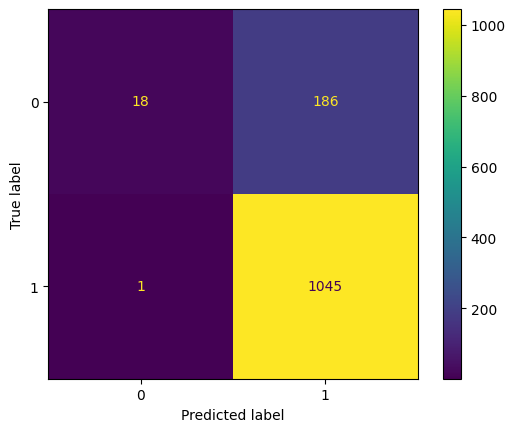

In [22]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
conf_matrix.plot()
plt.show()

### Re-train SVC model with the objective that >50% of the predictions for each class is predicted correctly
- Update hyperparameters appropriately to achieve the stated objective


In [23]:
model2 = SVC(class_weight='balanced', kernel='linear', coef0=0.1, probability=True)
model2.fit(X_train,y_train)

SVC(class_weight='balanced', coef0=0.1, kernel='linear', probability=True)

### Evaluate updated SVC model

In [24]:
# Display accuracy
y_pred = model2.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%")

Accuracy: 87.92%


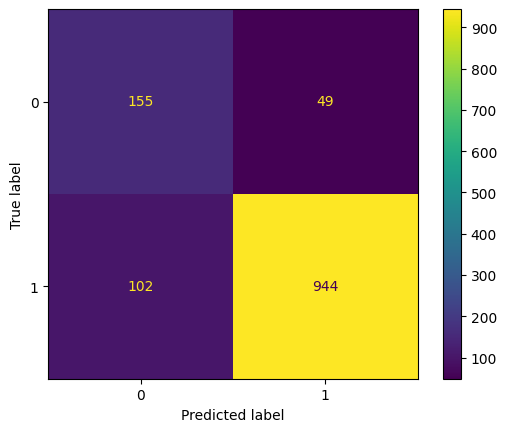

In [25]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
conf_matrix.plot()
plt.show()